# IDEAS

### Inspiring Kernels
* https://www.kaggle.com/harvinderwazir/match-outcome-prediction-in-football

* https://www.kaggle.com/stvrdo/goals-ratings-simulations/notebook

* https://www.kaggle.com/petehodge/epl-weekly-predicting/notebook
    
### VISUALIZATIONS - MUY IMPORTANTE
[Seventeen Ways to Map Data in Kaggle kernels](http://blog.kaggle.com/2016/11/30/seventeen-ways-to-map-data-in-kaggle-kernels/) 


## Background


# TYPE FROM PROPOSAL


# Data Preprocessing

### Type of data

The dataset is available at https://www.kaggle.com/hugomathien/soccer/data. The data is in the form of a sqlite database. 

### About the data

The data contains the following tables:

*** Country, League, Match, Player, Player_Attributes, Team, Team_Attributes***

The tables *country, league, player and team* are lookup tables. Lets focus on the table with attributes - Player_Attributes, Team_Attributes and Match.
In the following code cell, I read the SQLITE table and display the first record of all these three tables.

In [7]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import data_preprocess as dp
# Import supplementary visualization code visuals.py, renamed as visuals_udacity.py. I have taken this code from the Udacity
# machine learning projects
from Utils import *

# Pretty display for notebooks
%matplotlib inline
conn = dp.uncompress_and_open_sqlite()
print ("Players")
players_df = dp.sql_to_dataframe(conn, select_all_query_table("Player_Attributes"))
display(players_df.head(n=1))
print ("Teams")
teams_df = dp.sql_to_dataframe(conn, select_all_query_table("Team_Attributes"))
display(teams_df.head(n=1))
print ("Matches")
match_df = dp.sql_to_dataframe(conn, select_all_query_table("Match"))
display(match_df.head(n=1))

Players


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


Teams


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover


Matches


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.4,4.5,1.78,3.25,4.0,1.73,3.4,4.2


### Defining the data features and labels
* Players : 

In [2]:
players_skills = players_df[['player_api_id', 'finishing', 'sliding_tackle', 'gk_reflexes', 'short_passing', 'date']]
players_ratings_label = players_df[['player_api_id','date', 'overall_rating']]
players_features_df = players_df.drop(['id', 'player_fifa_api_id', 'player_api_id', 'date', 'overall_rating', 'potential'], axis=1)
display(players_features_df.head(n=1))

,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0


* Teams
No output label. I'll drop the metadata to get features.

In [3]:
teams_features_df = teams_df.drop(['id', 'team_fifa_api_id', 'team_api_id', 'date'], axis=1)
display(teams_features_df.head(n=1))

,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover


### Generating output labels

The matches have the goals score information (by home and away) teams; however don't have a label. I am generating a label, based on the goals scored.

#### Get match results
In the following code cell, I apply a lambda function to get the result label as either ['Home Win', 'Away Win', 'Draw']. 

In [4]:
import matches as matches
match_df['result_label'] = match_df.apply(matches.result, axis = 1)
display(match_df.result_label.sample(n=10))

4709         DRAW
18451    HOME_WIN
3094         DRAW
22125    HOME_WIN
21944    AWAY_WIN
9405     HOME_WIN
21913    AWAY_WIN
23211    AWAY_WIN
16454    AWAY_WIN
8320         DRAW
Name: result_label, dtype: object

### Defining the base classifier: The home advantage
Now that we have our labels defined, let us define the **baseline classifier**.
Home advantage is real, as mentioned in the Kaggle link, as well as here: http://bleacherreport.com/articles/1604854-how-much-does-home-field-advantage-matter-in-soccer. Lets analyze the home advantage across different leagues.

In [5]:
import data_preprocess as dp
reload(dp)
home_advantage_per_country = dp.home_advantage(matches_df=match_df, conn=conn)
display(home_advantage_per_country)
total_num_matches = match_df.shape[0]
total_home_wins = match_df[match_df['result_label'] == 'HOME_WIN'].shape[0]
total_away_wins = match_df[match_df['result_label'] == 'AWAY_WIN'].shape[0]
print ("Home Wins occur about " + str(np.around(np.true_divide(total_home_wins, total_num_matches), decimals = 2)) + " % of the time")
print ("Away Wins occur about " + str(np.around(np.true_divide(total_away_wins, total_num_matches), decimals = 2)) + " % of the time")

,name,percentage_home_win
0,Belgium,46.875000
1,England,45.723684
2,France,44.703947
3,Germany,45.220588
4,Italy,46.635731
5,Netherlands,47.834967
6,Poland,45.312500
7,Portugal,44.249513
8,Scotland,41.666667
9,Spain,48.848684


Home Wins occur about 0.46 % of the time
Away Wins occur about 0.29 % of the time


#### Observations:
Home advantage is indeed real; and consistent across all countries. ALWAYS predicting a home win would result us in being correct 46% of the time; and therefore our **baseline accuracy with a naive model is 46%.**
I would like to use this to some effect while engineering features. I believe such stats might help:
* Home team's track record playing at home
* Away team's track record playing away 
* Away team's track record playing at the location the current match is at

More on this in the section on features.

#### Visualizing player ratings
A histogram visualization to view player distributions in terms of ratings will be helpful. I will be using this to gain intution for features such as 'players_in_top_X_percent'. Sometimes a single ***star player*** can win a match for their team; and that is my intuition behind these features.

(63.5, 73.667]      0.530580
(73.667, 83.833]    0.230843
(53.333, 63.5]      0.197029
(43.167, 53.333]    0.022057
(83.833, 94.0]      0.013904
(32.938, 43.167]    0.001044
Name: overall_rating, dtype: float64

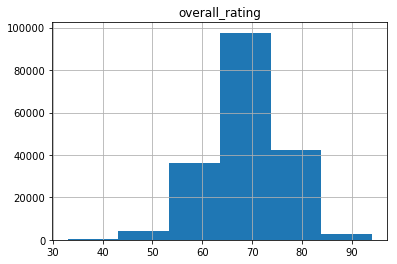

In [6]:
import matplotlib.pyplot as plt
# Visualize player ratings
players_df.hist(column= 'overall_rating', bins = 6)
players_df['overall_rating'].value_counts(bins = 6, normalize=True)

#### Defining the problems

* The holy grail is predicting the outcome of a football match, as mentioned in the kaggle link for the dataset I intend to use 

* Cluster matches based on the excitement level and interest in the game; possibly use this to model ticket prices. I would guess that a match between Real Madrid and Barcelona would be the most expensive. What factors make fans pay more for a match? If I follow a certain team, how much money can I expect to shell out?

* Model players and teams; and assign them a quantifiable number that serves as a rating of skill. I would like to find the answer to the pull of star power; many people tune in to football matches to watch Messi, Neymar or Ronaldo. Note that the capability of players also affects the excitement surrounding football matches.

* The main service they provided is advice to teams on whether or not a player should be bought or sold, not sure if this would be of any help, one of they key concepts they discussed was coming up with a metric on players on how much of an impact the player makes which was calculated by figuring out a team's performance with and without that particular player while taking into account other players and different circumstances.
**Background**
Players get injured all the time, with managers complaning about injuries (insert link). Through this part of the code, I wish to answer this queation: ***How does the team fare if player X is out due to injury for T% of the season?***. For eg. : How does Barcelona do in season 2011-12, had Messi not been there?

### Handling Bad Data

The Kaggle page does say that some input values are missing, and indeed it does. In this code block, I wish to eliminate some of the data where features I think are relevant (more discussion on this in the section on Feature generation). The columns are defined in the Utils.py file in the code. For now, I will be focusing on the match dataframe.

For this I use the *dropna* method in pandas. I certainly do not want to blindly check for validity of all columns in the match; a lot of it is information I don't think is necessary for prediction (bettting data, corners for example); atleast for the problem of determining match results.

Therefore I define the columns IMPORTANT to me, in the aptly named variable.
Luckily, even if I drop the data if ***any*** of the player ratings is absent, I do not lose a lot of data; as shown in the example below.

### TODO: Different processing for the match excitement clustering problem

In [7]:
import Utils as Utils
reload(Utils)
IMPORTANT_COLUMNS = Utils.AWAY_PLAYER_COLUMNS + Utils.HOME_PLAYER_COLUMNS
print ("Number of samples before removing cases of no data: " + str(match_df.shape[0]))
match_clean_data_df = match_df.dropna(axis = 0, how = 'any', subset = IMPORTANT_COLUMNS)
print ("Number of samples after removing cases of no data: " + str(match_clean_data_df.shape[0]))

Number of samples before removing cases of no data: 25979
Number of samples after removing cases of no data: 21374


# Feature Selection

In this section, I generate some features from the given match data, that I think are relevant from my domain knowledge of football.

## TODO: WRITE ABOUT HOW YOU LEARNT ABOUT LAMBDA AND PARTIAL HERE.

### Utility APIs for features
The following code blocks demonstrates the use of some util methods I have in my code, to help get some features from the raw data for the task of match prediction. 

#### Acknowledgement: Thanks to the author of https://www.kaggle.com/harvinderwazir/match-outcome-prediction-in-football/notebook ; for neatly putting up the relevant column names for a particular task! :)

#### Classify a player into midfield, attack and defense
Takes in as an input the relevant player skills and classifies into midfielder, attacker, defender or goalkeeper; based on the most recent numbers from the database. Here I validate my method against the famous players (3 of each of the 4 types) who I know i can classify into the aforementioned categories.
As can be seem from the results (and if you know your football :), my method takes a good decision from the columns of interest. The reason I wish to make this distinction is to better divide a team's rating based on players into defense, attack and midfield; rather than an overall average rating. I will be using this more further in the section on Features and Classification.

In [8]:
import players as players
reload(players)
player_names_df = dp.sql_to_dataframe(conn, select_all_query_table("Player"))
FAMOUS_PLAYER_NAMES = ['Lionel Messi', 'Cristiano Ronaldo', 'Didier Drogba', 'John Terry', 
                'Rio Ferdinand', 'Gerard Pique', 'Petr Cech', 'Iker Casillas', 
                'Joe Hart', 'Frank Lampard', 'Xavi Hernandez', 'Andres Iniesta']
COLUMNS_OF_INTEREST = ['player_name', 'finishing', 'sliding_tackle',
                     'gk_reflexes', 'short_passing']
for player in FAMOUS_PLAYER_NAMES:
    display(players.player_to_player_type(players_skills=players_skills, player_names_df=player_names_df, 
                                      player_name=player, COLUMNS_OF_INTEREST=COLUMNS_OF_INTEREST))

players.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  latest_skills_df['player_type'] = latest_skills_df.idxmax(axis=1)
players.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  latest_skills_df['player_name'] = player_name
players.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  latest_skills_df['player

,player_name,player_type,player_api_id
102482,Lionel Messi,Attacker,30981


,player_name,player_type,player_api_id
33330,Cristiano Ronaldo,Attacker,30893


,player_name,player_type,player_api_id
43418,Didier Drogba,Attacker,30822


,player_name,player_type,player_api_id
84848,John Terry,Defender,30627


,player_name,player_type,player_api_id
149835,Rio Ferdinand,Defender,30620


,player_name,player_type,player_api_id
62977,Gerard Pique,Defender,37482


,player_name,player_type,player_api_id
142868,Petr Cech,Goalkeeper,30859


,player_name,player_type,player_api_id
72590,Iker Casillas,Goalkeeper,30657


,player_name,player_type,player_api_id
83352,Joe Hart,Goalkeeper,31432


,player_name,player_type,player_api_id
59244,Frank Lampard,Midfielder,30631


,player_name,player_type,player_api_id
180709,Xavi Hernandez,Midfielder,39854


,player_name,player_type,player_api_id
12773,Andres Iniesta,Midfielder,30955


I will now run this on all players and create a lookup dictionary to look up player type by player ID; this will speed up the later process of aggregating team ratings by type. *Note that the assumption here is that a player does not change his type on the field, therefore we just use the latest value for his skills to determine his type.*

In [ ]:
unique_player_list = set(players_skills['player_api_id'].tolist())
player_to_player_type_dict=dict()
import Utils as Utils
reload(Utils)
import json

# TODO: Move SKILL COLUMNS to Utils.py
player_num = 0
for player_api_id in unique_player_list:
    player_num = player_num + 1
    if player_num % 1000 == 0:
        print ("Done with " + str(player_num) + " players")
    player_to_player_type_dict[player_api_id] = players.player_api_id_to_player_type(players_skills=players_skills, 
                                                               COLUMNS_OF_INTEREST=Utils.SKILL_COLUMNS,
                                                               player_api_id=player_api_id)
with open('Data_Structures/player_to_player_type.json', 'w+') as outfile:
     json.dump(player_to_player_type_dict, outfile, indent = 4,
               ensure_ascii = False)
print "Done creating the dictionary and wrote to file"

Done with 1000 players
Done with 2000 players
Done with 3000 players
Done with 4000 players
Done with 5000 players
Done with 6000 players
Done with 7000 players
Done with 8000 players
Done with 9000 players
Done with 10000 players
Done with 11000 players
Done creating the dictionary and wrote to file


#### Get Average Player Ratings For Match
Takes as an input a match, and returns back the ratings in the form of [midfielder_rating, attacker_rating, defender_rating, goalie_rating] for both the teams. Note that the ratings are based on the first ratings back in time I can find from that season; this is because every player has multiple ratings spread across time. For eg. for 2012-13, I will look for the date closest to Dec 31 2012 and take the player's ratings for that date.

Sometimes, I observed a team has no attacking players (rare, but not impossible); a team might decide to just play defenders and midfielders. In that case, I assign the attacking rating as 0.

#### Team rating without player
Removes a particular player under consideration, and then randomly chooses any of the other 10 to replace him. Across a season or some amount of matches, this is to mimic how a team performs if a particular player is out injured for the season, or his impact on the team if he were to leave the team.

Demonstrating the use of both APIs in the code cell below.

In [ ]:
import matches as matches
reload(matches)
import players as players
reload(players)
from functools import partial
import json
import Utils as Utils
reload(Utils)
with open('Data_Structures/player_to_player_type.json') as data_file:    
    player_to_player_type_dict = json.load(data_file)   
player_types= Utils.PLAYER_TYPES
# Just for generating features..

player_types= ['Midfielder']
team_types=['away', 'home']
display(match_clean_data_df.head(n=1))

# USE THIS TO COMBINE: https://stackoverflow.com/questions/19125091/pandas-merge-how-to-avoid-duplicating-columns --> #USE SUFFIXES
FEATURE_COLUMNS = []
for player_type_input in player_types:
    for team_type in team_types:
        FEATURE = team_type + "_" + player_type_input + "_rating"
        FEATURE_COLUMNS.append(FEATURE)
        print ("Evaulating feature " + FEATURE)
        get_feature = partial(matches.single_match_rating,players_ratings_label=players_ratings_label, 
                             player_to_player_type_dict=player_to_player_type_dict, 
                              player_type_input=player_type_input, team_type=team_type)
        match_clean_data_df[FEATURE] = match_clean_data_df.apply(get_feature, axis = 1)

        COLUMNS_TO_SAVE = ['match_api_id', 'home_team_api_id', 'away_team_api_id', 'season', 'date', 'result_label'] + FEATURE_COLUMNS
        display(match_clean_data_df[COLUMNS_TO_SAVE].head(n=10))
        match_clean_data_df[COLUMNS_TO_SAVE].to_csv("match_features_so_far_3.csv")

### Form Number stats features generation
### Here are the features I generated from the raw data, based on my intuition.

- HOME TEAM ALL TIME HOME RECORD AND RECORD THIS SEASON THUS FAR
- AWAY TEAM AWAY RECORD - ALL TIME AND THIS SEASON THUS FAR
- AWAY TEAM AWAY RECORD AT THIS GROUND- ALL TIME
- TEAMS HEAD TO HEAD
- TEAM FORM GUIDE - last 5 matches,  DEFINE IT AS A STRING; and ENCODE TO CATEGORIAL VALUE - CATEGORIAL LABELS

Order - the last match is at the front of the string; therefore if in this season, a team lost its last 2 matches and the won the three before those, form guide will be LLWWW.

### Note that the code below is an example of how to use the APIs, I rant this code from the main of my function to generate these features.

In [ ]:
from form_stats import *
all_features_df = pd.read_csv('Data_Structures/MATCH_FEATURES.csv')
FORM_STATS_FEATURES = ['match_api_id', 'home_team_api_id', 'away_team_api_id',
                   'season', 'date', 'result_label']
all_features_df['date'] = pd.to_datetime(all_features_df['date'])

match_sample = all_features_df

print "Getting head to head home win rate"
get_head_to_head = partial(head_to_head, full_df=all_features_df, value = "Home Win")
match_sample['HEAD_2_HEAD_HOME_TEAM_WINS'] = match_sample.apply(get_head_to_head, axis = 1)

print "Getting head to head home loss rate"
get_head_to_head = partial(head_to_head, full_df=all_features_df, value = "Home Loss")
match_sample['HEAD_2_HEAD_HOME_TEAM_LOSS'] = match_sample.apply(get_head_to_head, axis = 1)

print "Getting head to head draw rate"
get_head_to_head = partial(head_to_head, full_df=all_features_df, value = "Draw")
match_sample['HEAD_2_HEAD_DRAW'] = match_sample.apply(get_head_to_head, axis = 1)

print "Getting home win rate all time"
get_home_win_rate = partial(home_team_all_time_home_record, full_df=all_features_df)
match_sample['HOME_WIN_RATE'] = match_sample.apply(get_home_win_rate, axis = 1)

print "Getting home win rate this season"
get_home_win_rate_this_season = partial(home_team_this_season_home_record, full_df=all_features_df)
match_sample['HOME_WIN_RATE_THIS_SEASON'] = match_sample.apply(get_home_win_rate_this_season, axis = 1)

print "Getting away win rate all time"
get_away_win_rate = partial(away_team_all_time_away_record, full_df=all_features_df)
match_sample['AWAY_WIN_RATE'] = match_sample.apply(get_away_win_rate, axis = 1)

print "Getting away win rate this season"
get_away_win_rate_this_season = partial(away_team_this_season_away_record, full_df=all_features_df)
match_sample['AWAY_WIN_RATE_THIS_SEASON'] = match_sample.apply(get_away_win_rate_this_season, axis = 1)

print "Getting away team's win rate AT THIS GROUND"
get_away_win_rate_at_this_ground = partial(away_team_all_time_away_record_at_this_ground, full_df=all_features_df)
match_sample['AWAY_WIN_RATE_AT_THIS_GROUND'] = match_sample.apply(get_away_win_rate_at_this_ground, axis = 1)


match_sample.to_csv('Data_Structures/form_numbers.csv')

### Top and bottom tier players

Why do we need it? Often matches are won by a *brilliant player's moment of genius*; or a *bad player's mistake*. TODO: WRITE MORE WHY WE NEED THIS?

#### Top 1% of the players 
Based on the histogram above, I will define a top player to be a player with overall_rating > 80.

#### Bottom 1% of the players - analyze player distribution with histogram.
Based on the histogram above, I will define a bottom player to be a player with overall_rating < 50.

In [ ]:
import matches as matches
reload(matches)
from functools import partial

match_sample_df = match_clean_data_df
TOP_PLAYER_THRESHOLD = 80
BOTTOM_PLAYER_THRESHOLD = 50
COLUMNS_TO_SAVE = ['match_api_id']
# In the code, I have a cache that maintains a mapping of a player to his rating by season. So a key is player_api_id; that points to 
# a dictionary that contains rating for that player by season

print "Getting top players home"
get_top_players_home = partial(matches.top_players_in_team, players_ratings_label=players_ratings_label, 
                               team_type='home', TOP_PLAYER_THRESHOLD = TOP_PLAYER_THRESHOLD)
match_sample_df['num_top_players_home'] = match_sample_df.apply(get_top_players_home, axis = 1)
COLUMNS_TO_SAVE.append('num_top_players_home')

match_sample_df[COLUMNS_TO_SAVE].to_csv('Data_Structures/num_player_stats.csv')

print "Getting top players away"
get_top_players_away = partial(matches.top_players_in_team, players_ratings_label=players_ratings_label, 
                               team_type='away', TOP_PLAYER_THRESHOLD = TOP_PLAYER_THRESHOLD)
match_sample_df['num_top_players_away'] = match_sample_df.apply(get_top_players_away, axis = 1)
COLUMNS_TO_SAVE.append('num_top_players_away')

match_sample_df[COLUMNS_TO_SAVE].to_csv('Data_Structures/num_player_stats.csv')

print "Getting bottom players home"
get_bottom_players_home = partial(matches.bottom_players_in_team, players_ratings_label=players_ratings_label, 
                               team_type='home', BOTTOM_PLAYER_THRESHOLD = BOTTOM_PLAYER_THRESHOLD)
match_sample_df['num_bottom_players_home'] = match_sample_df.apply(get_bottom_players_home, axis = 1)
COLUMNS_TO_SAVE.append('num_bottom_players_home')

match_sample_df[COLUMNS_TO_SAVE].to_csv('Data_Structures/num_player_stats.csv')

print "Getting bottom players away"
get_bottom_players_away = partial(matches.bottom_players_in_team, players_ratings_label=players_ratings_label, 
                               team_type='away', BOTTOM_PLAYER_THRESHOLD = BOTTOM_PLAYER_THRESHOLD)
match_sample_df['num_bottom_players_away'] = match_sample_df.apply(get_bottom_players_away, axis = 1)
COLUMNS_TO_SAVE.append('num_bottom_players_away')


match_sample_df[COLUMNS_TO_SAVE].to_csv('Data_Structures/num_player_stats.csv')
print "DONE"

### Some notes about the feature process

* **Learning pandas, lambdas and partial** - generating my intuition to features, required the use of knowing these.

* Saving and re-working. I learnt it this the hard way; saving feature generation into apt csv files is VERY IMPORTANT, from time to time. MENTION HOW YOU USED DICTIONARIES TO SAVE YOUR WORK AND SPEED UP FEATURE GENERATION.

### Plotting some observations from the stats features
Now that we have our features (phew!), lets see if we can see something. For example, here is FC Barcelona's home record with respect to time. For ease, I am getting a dictionary that maps name to team_api_id first; and then using the team_api_id to get the stats.

,match_api_id,num_top_players_home,num_top_players_away,num_bottom_players_home,num_bottom_players_away,home_team_api_id,away_team_api_id,season,date,result_label,...,HEAD_2_HEAD_HOME_TEAM_WINS,HEAD_2_HEAD_HOME_TEAM_LOSS,HEAD_2_HEAD_DRAW,HOME_WIN_RATE,HOME_WIN_RATE_THIS_SEASON,AWAY_WIN_RATE,AWAY_WIN_RATE_THIS_SEASON,AWAY_WIN_RATE_AT_THIS_GROUND,HOME_TEAM_FORM_GUIDE,AWAY_TEAM_FORM_GUIDE
15264,1256352,0,0,0,0,10212,10215,2012/2013,9/30/12,AWAY_WIN,...,0.750000,0.000000,0.250000,0.416667,0.000000,0.184211,0.000000,0.000000,DDLWD,LLDLL
771,1677190,0,0,0,0,9991,9989,2013/2014,5/3/14,HOME_WIN,...,0.500000,0.500000,0.000000,0.574074,0.500000,0.083333,0.000000,0.000000,DWWLL,LLLDD
4401,483483,1,2,0,0,8639,8592,2008/2009,4/26/09,AWAY_WIN,...,0.297527,0.640812,0.061661,0.733333,0.733333,0.642857,0.642857,0.546939,LDWWW,WWWWW
6183,1468493,4,0,0,0,8592,9851,2013/2014,3/22/14,AWAY_WIN,...,0.500000,0.100000,0.400000,0.556604,0.500000,0.298077,0.214286,0.200000,DLLWD,LLLWD
14046,1983473,0,0,0,0,9803,8611,2015/2016,2/13/16,AWAY_WIN,...,0.090909,0.636364,0.272727,0.385542,0.272727,0.413793,0.000000,0.400000,DDWWL,WLLWL
2366,1024943,0,1,0,0,9850,10261,2011/2012,12/10/11,HOME_WIN,...,0.225397,0.612698,0.161905,0.428571,0.428571,0.227273,0.428571,0.000000,LWLLD,LDLWW
16021,490119,2,0,0,0,8548,9938,2008/2009,1/31/09,HOME_WIN,...,0.000000,0.000000,1.000000,0.818182,0.818182,0.300000,0.300000,0.000000,DWWLW,WLDDD
19836,1778115,0,7,0,0,8305,9906,2014/2015,10/26/14,AWAY_WIN,...,0.181818,0.545455,0.272727,0.433962,0.500000,0.381818,0.500000,0.333333,WDWLL,WLWWD
8450,1239508,0,0,0,0,8226,9904,2012/2013,9/23/12,HOME_WIN,...,0.333333,0.333333,0.333333,0.338462,0.000000,0.253968,1.000000,0.000000,LDWLD,LWLLW
17525,530341,7,5,0,0,8633,8302,2008/2009,12/7/08,AWAY_WIN,...,0.606803,0.393197,0.000000,1.000000,1.000000,0.400000,0.400000,0.370408,LLWDL,LDLLW


(array([ 733408.,  733773.,  734138.,  734503.,  734869.,  735234.,
         735599.,  735964.]), <a list of 8 Text xticklabel objects>)

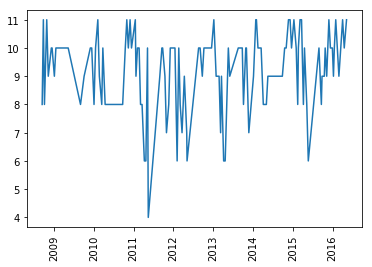

In [19]:
import data_preprocess as dp
reload(dp)
import pandas as pd
match_features_all_df = pd.read_csv('Data_Structures/FINAL_ALL_FEATURES_NO_NAN.csv')
display(match_features_all_df.sample(n=10))

team_df = sql_to_dataframe(conn, select_all_query_table("Team"))
team_name_to_id_dict = dp.get_team_name_to_team_api_id_dict(team_df)
CLUB = 'FC Barcelona'
barca_api_id = (int(team_name_to_id_dict[CLUB]))


# Factor this out into a function.
barca_top_players_num = match_features_all_df[match_features_all_df['home_team_api_id'] == barca_api_id]

barca_top_players_num.date = pd.to_datetime(barca_top_players_num.date)
barca_top_players_num = barca_top_players_num.sort_values('date', ascending=True)
barca_top_players_num=barca_top_players_num.dropna(how='any')
plt.plot(barca_top_players_num['date'], barca_top_players_num['num_top_players_home'])
plt.xticks(rotation='vertical')


### Filling the NaN values
* **The NaN case**- As shown in the feature definitions below, what if we don't have the history to get those stats? For eg. if this is the first team these teams are meeting (as per our data); we cannot say what the home to home stats are. Similary for form guide, I need *atleast five matches* to get a good estimate. When such history was not avaialble, I replaced the value with np.nan. Now to fill these NaN Valyes up, I could use the [Imputer method](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) given by scikit, however decided to just implement my own logic. The reason is that I want to have some logic in replacing the NaN values, for example:

    - For a team's home record that season, I will take the mean of the other values for the season. Note that only the first entry will be missing in this case for a team (the first home game of the season).
    - For head to head, I will replace np.na with the most common form guide for that team that season.
    
# TODO: Elaborate more on your fill nan strategies..

* HEAD_2_HEAD_HOME_TEAM_WINS, HEAD_2_HEAD_HOME_TEAM_LOSS, HEAD_2_HEAD_DRAW : Take all head to head matches, and replace np.nan with the mean of all non nan values. It is possible that some teams have NEVER played before, in which case I will just randomly assign a value of 0.33 to each of the three events (equal probability of happening).

* AWAY_WIN_RATE_AT_THIS_GROUND : Find all samples where this team played away at this home team's ground; and take average. If this team has never played here; just take the average of its all time away record. Note that this is rare, but possible. If this team has never played away other than this ins
##### Of course I could throw out this data that is na for my features, but the idea of throwing out data broke my heart...

## NOTE: I VALIDATE NO NaNs are left, using 'isnull.values.any' after each column

## Here is the list of all possibilities for form guide. If there is a nan, and there is no other data for that team, I will randomly replace with one of the 243 possibilities. (3 options for 5 matches, 3^5)

In [2]:
import itertools
all_possibilities_form_guide = list(itertools.product(['L', 'W', 'D'], repeat=5))
all_possibilities_form_guide_string_list = list()
for possibility in all_possibilities_form_guide:
    all_possibilities_form_guide_string_list.append(''.join(possibility))
#print all_possibilities_form_guide_string_list
assert len(all_possibilities_form_guide_string_list) == 243

In [131]:
from functools import partial
#match_features_sample = match_features_all_df[match_features_all_df['match_api_id']==493017]
match_features_sample = match_features_all_df
COLUMNS_TO_NAN_FILL= ['HEAD_2_HEAD_HOME_TEAM_WINS', 'HEAD_2_HEAD_HOME_TEAM_LOSS', 'HEAD_2_HEAD_DRAW', 'HOME_WIN_RATE',
                     'AWAY_WIN_RATE', 'AWAY_WIN_RATE_AT_THIS_GROUND', 'AWAY_WIN_RATE_THIS_SEASON', 'HOME_TEAM_FORM_GUIDE',
                     'AWAY_TEAM_FORM_GUIDE']


import nan_filler as nf
reload(nf)
display(match_features_sample[COLUMNS_TO_NAN_FILL].shape)
print "Filling NaN for home_team_form_guide"
nan_fill_home_team_form_guide = partial(nf.fill_nan_form_guide, full_df=match_features_all_df, team_type='home', 
                                        all_possibility=all_possibilities_form_guide_string_list)
match_features_sample['HOME_TEAM_FORM_GUIDE'] = match_features_sample.apply(nan_fill_home_team_form_guide, axis = 1)

print "Filling NaN for away_team_form_guide"
nan_fill_away_team_form_guide = partial(nf.fill_nan_form_guide, full_df=match_features_all_df, team_type='away',
                                       all_possibility=all_possibilities_form_guide_string_list)
match_features_sample['AWAY_TEAM_FORM_GUIDE'] = match_features_sample.apply(nan_fill_away_team_form_guide, axis = 1)

print "Filling NaN for away_team_win_rate_at_this_ground"
nan_fill_away_team_win_rate_at_this_ground = partial(nf.fill_nan_away_team_win_rate_all_time_at_this_ground, full_df=match_features_all_df)
match_features_sample['AWAY_WIN_RATE_AT_THIS_GROUND'] = match_features_sample.apply(nan_fill_away_team_win_rate_at_this_ground, axis = 1)

print "Filling NaN for head to head home win rate"
nan_fill_head_to_head_wins = partial(nf.fill_nan_head_2_head_home_team_win_rate, full_df=match_features_all_df)
match_features_sample['HEAD_2_HEAD_HOME_TEAM_WINS'] = match_features_sample.apply(nan_fill_head_to_head_wins, axis = 1)
    
print "Filling NaN for head to head home loss rate"
nan_fill_head_to_head_loss = partial(nf.fill_nan_head_2_head_home_team_loss_rate, full_df=match_features_all_df)
match_features_sample['HEAD_2_HEAD_HOME_TEAM_LOSS'] = match_features_sample.apply(nan_fill_head_to_head_loss, axis = 1)
    
print "Filling NaN for head to head draw rate"
nan_fill_head_to_head_draw = partial(nf.fill_nan_head_2_head_draw, full_df=match_features_all_df)
match_features_sample['HEAD_2_HEAD_DRAW'] = match_features_sample.apply(nan_fill_head_to_head_draw, axis = 1)
    
print "Filling NaN for home team all time win rate"
nan_fill_home_team_win_rate_all_time = partial(nf.fill_nan_home_team_win_rate_all_time, full_df=match_features_all_df)
match_features_sample['HOME_WIN_RATE'] = match_features_sample.apply(nan_fill_home_team_win_rate_all_time, axis = 1)

print "Filling NaN for away team all time win rate"
nan_fill_away_team_win_rate_all_time = partial(nf.fill_nan_away_team_win_rate_all_time, full_df=match_features_all_df)
match_features_sample['AWAY_WIN_RATE'] = match_features_sample.apply(nan_fill_away_team_win_rate_all_time, axis = 1)


print "Filling NaN for home team win rate this season"
nan_fill_home_team_win_rate_this_season = partial(nf.fill_nan_home_team_win_rate_this_season, full_df=match_features_all_df)
match_features_sample['HOME_WIN_RATE_THIS_SEASON'] = match_features_sample.apply(nan_fill_home_team_win_rate_this_season, axis = 1)

print "Filling NaN for away team win rate this season"
nan_fill_away_team_win_rate_this_season = partial(nf.fill_nan_away_team_win_rate_this_season, full_df=match_features_all_df)
match_features_sample['AWAY_WIN_RATE_THIS_SEASON'] = match_features_sample.apply(nan_fill_away_team_win_rate_this_season, axis = 1)

print "Filling NaN for away team win rate at this ground"
nan_fill_away_team_win_rate_at_this_ground = partial(nf.fill_nan_away_team_win_rate_all_time_at_this_ground, full_df=match_features_all_df)
match_features_sample['AWAY_WIN_RATE_AT_THIS_GROUND'] = match_features_sample.apply(nan_fill_away_team_win_rate_at_this_ground, axis = 1)


display(match_features_sample[COLUMNS_TO_NAN_FILL].shape)

for column in COLUMNS_TO_NAN_FILL:
    if (match_features_sample[column].isnull().values.any()):
        print (column)
        raise Exception

match_features_sample.to_csv('FINAL_ALL_FEATURES_NO_NAN.csv')



(21374, 9)

Filling NaN for home_team_form_guide
Filling NaN for away_team_form_guide
Filling NaN for away_team_win_rate_at_this_ground
Filling NaN for head to head home win rate
Filling NaN for head to head home loss rate
Filling NaN for head to head draw rate
Filling NaN for home team all time win rate
Filling NaN for away team all time win rate
Filling NaN for home team win rate this season
Filling NaN for away team win rate this season
Filling NaN for away team win rate at this ground


(21374, 9)

## Almost there..

Phew! Generating features was fun (and tedious). Now just need to do the following steps..

### Convert form guide to labelled
### One hot encode the output labels.
### Drop metadata such as match_api_id, home_team_api_id etc.

In [174]:
import pandas as pd
from IPython.display import display
final_all_features = pd.read_csv('Data_Structures/FINAL_ALL_FEATURES_NO_NAN.csv')


# Drop metadata
META_COLUMNS=['match_api_id', 'home_team_api_id', 'away_team_api_id', 'season', 'date']


final_all_features = final_all_features.drop(META_COLUMNS, axis =1)

# Drop na
display(final_all_features.shape)
final_all_features = final_all_features.dropna(axis = 0, how = 'any')
display(final_all_features.shape)

## Convert form guide to labelled
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_possibilities_form_guide_string_list)
final_all_features['HOME_TEAM_FORM_GUIDE'] = le.transform(final_all_features['HOME_TEAM_FORM_GUIDE'])
final_all_features['AWAY_TEAM_FORM_GUIDE'] = le.transform(final_all_features['AWAY_TEAM_FORM_GUIDE'])


LABELS = ['HOME_WIN', 'AWAY_WIN', 'DRAW']
le.fit(LABELS)
transformed_labels = le.transform(final_all_features['result_label'])

# Draw features and labels
le_draw = preprocessing.LabelEncoder()
DRAW_LABELS = ['HOME_WIN', 'AWAY_WIN']
le_draw.fit(DRAW_LABELS)
final_all_features_no_draws = final_all_features[final_all_features['result_label'] != 'DRAW']
transformed_labels_no_draws = le_draw.transform(final_all_features_no_draws['result_label'])

final_all_features = final_all_features.drop(['result_label'], axis =1)
final_all_features_no_draws = final_all_features_no_draws.drop(['result_label'], axis =1)

display(final_all_features.dtypes)


(21374, 23)

(21360, 23)

num_top_players_home              int64
num_top_players_away              int64
num_bottom_players_home           int64
num_bottom_players_away           int64
away_Attacker_rating            float64
home_Attacker_rating            float64
away_Defender_rating            float64
home_Defender_rating            float64
away_Goalkeeper_rating          float64
home_Goalkeeper_rating          float64
away_Midfielder_rating          float64
home_Midfielder_rating          float64
HEAD_2_HEAD_HOME_TEAM_WINS      float64
HEAD_2_HEAD_HOME_TEAM_LOSS      float64
HEAD_2_HEAD_DRAW                float64
HOME_WIN_RATE                   float64
HOME_WIN_RATE_THIS_SEASON       float64
AWAY_WIN_RATE                   float64
AWAY_WIN_RATE_THIS_SEASON       float64
AWAY_WIN_RATE_AT_THIS_GROUND    float64
HOME_TEAM_FORM_GUIDE              int64
AWAY_TEAM_FORM_GUIDE              int64
dtype: object

### Notes about the datatypes of the features GO HERE

# Model Fitting and Optimization

Now that we have our features (phew!) all encoded, and ready to go; we can try various classifiers. First, I will shuffle and split the data. 

## Need to scale? Don't think so, write about it.


# NOTE: Acknowledgement: Some code is based on charity ML's code

### Shuffle and split

In [175]:

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(final_all_features, 
                                                    transformed_labels, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 17088 samples.
Testing set has 4272 samples.


# TODO: DEFINE F SCORE FOR NAIVE CASE
### A training and predicting pipeline

### DEFINING A MULTI CLASS F SCORE


In [176]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = clf.predict(X_test)
    predictions_train = clf.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    
    betaValue = 0.6
    
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=betaValue,
                                     average='micro')
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=betaValue, 
                                    average='micro')  
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

QuadraticDiscriminantAnalysis trained on 170 samples.
QuadraticDiscriminantAnalysis trained on 1708 samples.
QuadraticDiscriminantAnalysis trained on 17088 samples.
MLPClassifier trained on 170 samples.
MLPClassifier trained on 1708 samples.
MLPClassifier trained on 17088 samples.
AdaBoostClassifier trained on 170 samples.
AdaBoostClassifier trained on 1708 samples.
AdaBoostClassifier trained on 17088 samples.


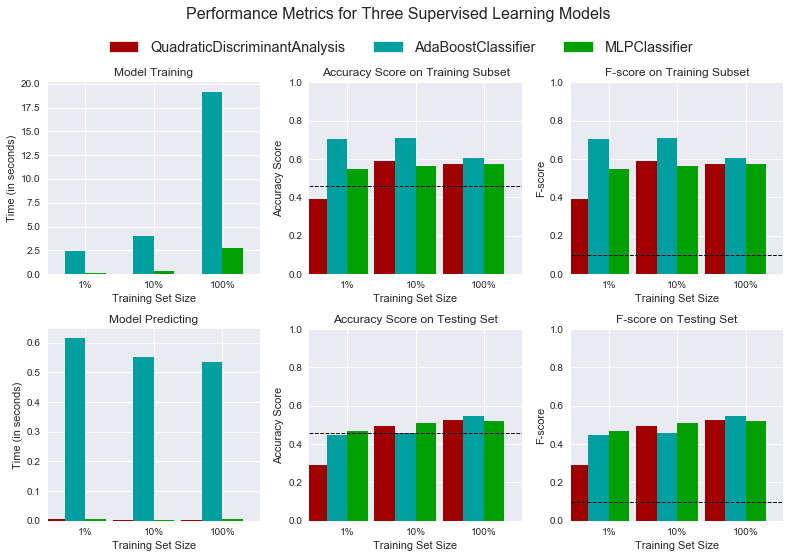

In [177]:

# TODO: Import the three supervised learning models from sklearn
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from math import floor
import visuals_udacity as vs
# TODO: Initialize the three models
clf_A = QuadraticDiscriminantAnalysis()
# Initializing with n_neighbors = 3
# TODO: Check deep learning
clf_B = MLPClassifier(solver='lbfgs', alpha=1e-5,
                   hidden_layer_sizes=(15, 15), random_state=1)
clf_C = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME.R",
                         n_estimators=1000, random_state = 1)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = int(.10 * len(y_train))
samples_1 = int(.01 * len(y_train))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)
# Run metrics visualization for the three supervised learning models chosen
DUMMY_BASE_ACCURACY = 0.46
DUMMY_BASE_F_SCORE = 0.1
vs.evaluate(results, DUMMY_BASE_ACCURACY, DUMMY_BASE_F_SCORE)

In [178]:
print results['AdaBoostClassifier']

{0: {'pred_time': 0.6157181262969971, 'f_test': 0.44967228464419473, 'train_time': 2.4316530227661133, 'acc_train': 0.70666666666666667, 'acc_test': 0.44967228464419473, 'f_train': 0.70666666666666655}, 1: {'pred_time': 0.5522139072418213, 'f_test': 0.45763108614232206, 'train_time': 4.0063440799713135, 'acc_train': 0.70999999999999996, 'acc_test': 0.45763108614232212, 'f_train': 0.70999999999999985}, 2: {'pred_time': 0.535768985748291, 'f_test': 0.54751872659176026, 'train_time': 19.183301210403442, 'acc_train': 0.60333333333333339, 'acc_test': 0.54751872659176026, 'f_train': 0.60333333333333339}}


# TODO: RUN A BUNCH OF CLASSIFIERS AND TABULATE RESULTS


[('AWAY_WIN_RATE_AT_THIS_GROUND', 10.800000000000001), ('home_Midfielder_rating', 9.9000000000000004), ('home_Defender_rating', 8.5999999999999996), ('AWAY_WIN_RATE', 8.3000000000000007), ('away_Midfielder_rating', 8.3000000000000007), ('HOME_WIN_RATE', 7.3999999999999995), ('HOME_TEAM_FORM_GUIDE', 5.5), ('away_Defender_rating', 5.2000000000000002), ('home_Attacker_rating', 5.0999999999999996), ('AWAY_TEAM_FORM_GUIDE', 4.5), ('away_Attacker_rating', 4.5)]


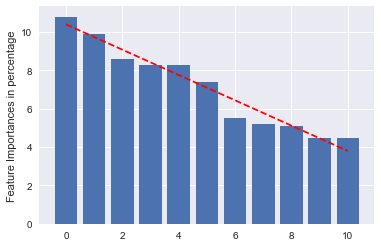

In [117]:
NUM_FEATURES = 12
dict_feature_names_to_importances = dict(zip(X_train.columns, clf_C.feature_importances_ * 100))
sorted_tuples = sorted(dict_feature_names_to_importances.items(), key=lambda x:x[1], reverse=True)
print sorted_tuples[0: NUM_FEATURES - 1]
# REFERENCE FOR GRAPH CODE: Thanks to https://stackoverflow.com/questions/13925251/python-bar-plot-from-list-of-tuples

# save the names and their respective scores separately
# reverse the tuples to go from most frequent to least frequent 
feature_names = zip(*sorted_tuples[0: NUM_FEATURES - 1])[0]
importances = zip(*sorted_tuples[0: NUM_FEATURES - 1])[1]
x_pos = np.arange(len(feature_names)) 

# calculate slope and intercept for the linear trend line
slope, intercept = np.polyfit(x_pos, importances, 1)
trendline = intercept + (slope * x_pos)

plt.plot(x_pos, trendline, color='red', linestyle='--')    
plt.bar(x_pos, importances,align='center')
plt.ylabel('Feature Importances in percentage')
plt.show()

## Notes About Feature Importance go here
- GOod to see form guides having some importance!
### Ah, all that work..

Seems that the features number of top players home/away, num of bottom players home/away are not useful at all. Lets drop the correlation matrix between the features.

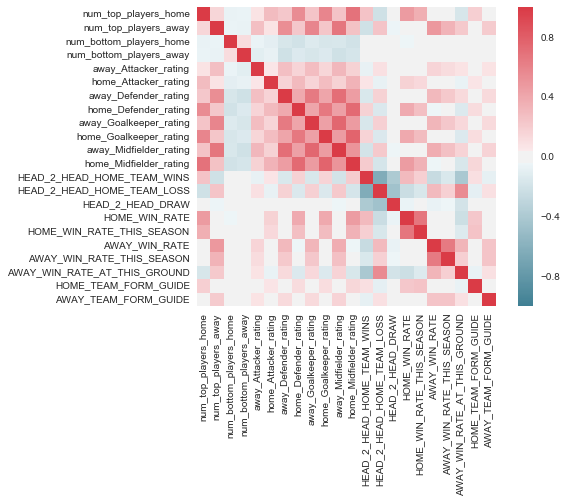

In [13]:
import seaborn as sns
corr = X_train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)

### Plot R2 scores!

#### Confusion Matrix
In the code cell below, I plot the confusion matrix for both the base case (always predicting a HOME_WIN); and a confusion matrix for the AdaBoost Classifier.

******************************************************************
Confusion matrix for base case
Normalized confusion matrix
[[ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]
******************************************************************
Confusion matrix for AdaBoost classifier
Normalized confusion matrix
[[ 0.51  0.08  0.42]
 [ 0.23  0.12  0.66]
 [ 0.14  0.06  0.8 ]]


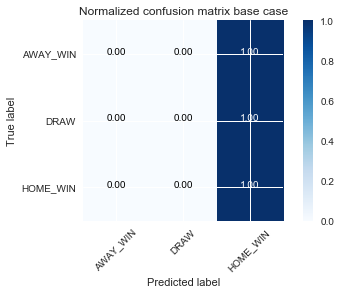

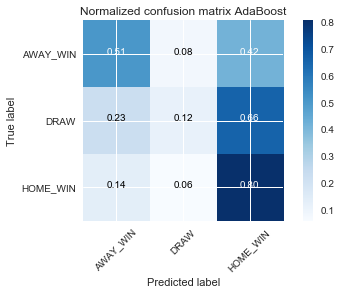

In [179]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

'''
CONFUSIOM MATRIX FOR BASE CASE
'''
y_base_pred = y_test.copy()
y_base_pred[:] = le.transform(['HOME_WIN'])
cnf_base_case_matrix = confusion_matrix(y_test, y_base_pred)

'''
CONFUSIOM MATRIX FOR ADABOOST
'''
y_pred = clf_C.predict(X_test)
cnf_matrix_adaboost = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)


CLASSES_NAME = le.inverse_transform([0,1,2])

print "******************************************************************"
print "Confusion matrix for base case"
plt.figure()
plot_confusion_matrix(cnf_base_case_matrix, classes=CLASSES_NAME, normalize=True,
                      title='Normalized confusion matrix base case')

print "******************************************************************"
print "Confusion matrix for AdaBoost classifier"
plt.figure()
plot_confusion_matrix(cnf_matrix_adaboost, classes=CLASSES_NAME, normalize=True,
                      title='Normalized confusion matrix AdaBoost')



### Hyperparameter tuning

It does seem that AdaBoost is the bect classifier for this task. Let's try to tune the hyperparameters for the classifier.

In [125]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
# TODO: Initialize the classifier
clf = AdaBoostClassifier()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
# I choose to perform a grid search on two params: the algorithm used for boosting and the number of estimators (early termination to avoid overfitting)
'''
MY BASE CLASSIFIER
clf_C = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME.R",
                         n_estimators=1000, random_state = 1)
                         
'''
parameters = {'base_estimator': [tree.DecisionTreeClassifier(max_depth=1),
                                tree.DecisionTreeClassifier(max_depth=2)], 
              'n_estimators': [1000], 
              'algorithm' : ['SAMME', 'SAMME.R'],
              'random_state' : [1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()

grid_obj = GridSearchCV(clf, parameters, scoring = scorer, verbose = 5) #Turned the verbose option when I was running it

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 
[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.468177, total=  12.5s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, ma

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.9s remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.462632, total=  13.1s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   26.4s remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.453482, total=  13.3s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   40.0s remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.483307, total=  22.9s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.485399, total=  22.9s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 
[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, mi

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  3.9min finished


In [126]:
# Get the estimator
best_clf = grid_fit.best_estimator_
print best_clf

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5, average='weighted'))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5, average='weighted'))

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=1000, random_state=1)
Unoptimized model
------
Accuracy score on testing data: 0.5382
F-score on testing data: 0.4653

Optimized Model
------
Final accuracy score on the testing data: 0.5447
Final F-score on the testing data: 0.4877


## Some observations based on best classifier's confusion matrix
### Home Wins
Based on the confusion matrix for the best classifier, it is pity good at predicting home wins. Through statistics in the section above, home wins occur for 46% of the time; and if that's a punt people take on statistics; so predicting 83% is really good.

### Away Wins
Away wins statistically occur 29% of the time, my model predicts the correct result for an away win 50% of the time.

### I suck at predicting draws..

As seen in the confusion matrix for my best classifier, AdaBoost; the model is terrible at predicting draws. Lets consider the accuracy of the model when we do not consider drawn matches.
## Now that I think about it, I did not generate features for draws, data such as away/home team's draw rate all time/ this season; could be helpful. So lets's try that!

### Here I generate and then nan-fill the draw data for the following five features (much in the same way it was done before)

# TODO: GENERATE DRAW FEATURES!
- HOME_DRAW_RATE                   float64
- HOME_DRAW_RATE_THIS_SEASON       float64
- AWAY_DRAW_RATE                   float64
- AWAY_DRAW_RATE_THIS_SEASON       float64
- AWAY_DRAW_RATE_AT_THIS_GROUND    float64

In [136]:
from form_stats import *
all_features_df = pd.read_csv('Data_Structures/ALL_MATCH_FEATURES.csv')
FORM_STATS_FEATURES = ['match_api_id', 'home_team_api_id', 'away_team_api_id',
                   'season', 'date', 'result_label']
all_features_df['date'] = pd.to_datetime(all_features_df['date'])
match_sample = all_features_df

print "Getting home draw rate all time"
get_home_draw_rate = partial(home_team_all_time_home_draws, full_df=all_features_df)
match_sample['HOME_DRAW_RATE'] = match_sample.apply(get_home_draw_rate, axis = 1)

print "Getting home draw rate this season"
get_home_draw_rate_this_season = partial(home_team_this_season_home_draws, full_df=all_features_df)
match_sample['HOME_DRAW_RATE_THIS_SEASON'] = match_sample.apply(get_home_draw_rate_this_season, axis = 1)

print "Getting away draw rate all time"
get_away_draw_rate = partial(away_team_all_time_away_draws, full_df=all_features_df)
match_sample['AWAY_DRAW_RATE'] = match_sample.apply(get_away_draw_rate, axis = 1)

print "Getting away draw rate this season"
get_away_draw_rate_this_season = partial(away_team_this_season_away_draw, full_df=all_features_df)
match_sample['AWAY_DRAW_RATE_THIS_SEASON'] = match_sample.apply(get_away_draw_rate_this_season, axis = 1)

print "Getting away team's draw rate AT THIS GROUND"
get_away_draw_rate_at_this_ground = partial(away_team_all_time_away_draws_at_this_ground, full_df=all_features_df)
match_sample['AWAY_DRAW_RATE_AT_THIS_GROUND'] = match_sample.apply(get_away_draw_rate_at_this_ground, axis = 1)

COLUMNS = ['match_api_id', 'HOME_DRAW_RATE', 'HOME_DRAW_RATE_THIS_SEASON', 'AWAY_DRAW_RATE', 'AWAY_DRAW_RATE_THIS_SEASON',
          'AWAY_DRAW_RATE_AT_THIS_GROUND']

match_sample[COLUMNS].to_csv("Data_Structures/draw_form_stats.csv")

Getting home draw rate all time
Getting home draw rate this season
Getting away draw rate all time
Getting away draw rate this season
Getting away team's draw rate AT THIS GROUND


### Nan fill draw data

In [143]:
from functools import partial
#match_features_sample = match_features_all_df[match_features_all_df['match_api_id']==493017]
match_features_all_df = pd.read_csv('Data_Structures/draw_join_features.csv')
match_features_sample = match_features_all_df
COLUMNS_TO_NAN_FILL= ['HOME_DRAW_RATE', 'HOME_DRAW_RATE_THIS_SEASON', 'AWAY_DRAW_RATE', 'AWAY_DRAW_RATE_THIS_SEASON',
          'AWAY_DRAW_RATE_AT_THIS_GROUND']


import nan_filler as nf
reload(nf)
display(match_features_sample[COLUMNS_TO_NAN_FILL].shape)

print "Filling NaN for home team all time draw rate"
nan_fill_home_team_draw_rate_all_time = partial(nf.fill_nan_home_team_draw_rate_all_time, full_df=match_features_all_df)
match_features_sample['HOME_DRAW_RATE'] = match_features_sample.apply(nan_fill_home_team_draw_rate_all_time, axis = 1)

print "Filling NaN for away team all time draw rate"
nan_fill_away_team_draw_rate_all_time = partial(nf.fill_nan_away_team_draw_rate_all_time, full_df=match_features_all_df)
match_features_sample['AWAY_DRAW_RATE'] = match_features_sample.apply(nan_fill_away_team_draw_rate_all_time, axis = 1)

print "Filling NaN for home team draw rate this season"
nan_fill_home_team_draw_rate_this_season = partial(nf.fill_nan_home_team_draw_rate_this_season, full_df=match_features_all_df)
match_features_sample['HOME_DRAW_RATE_THIS_SEASON'] = match_features_sample.apply(nan_fill_home_team_draw_rate_this_season, axis = 1)

print "Filling NaN for away team draw rate this season"
nan_fill_away_team_draw_rate_this_season = partial(nf.fill_nan_away_team_draw_rate_this_season, full_df=match_features_all_df)
match_features_sample['AWAY_DRAW_RATE_THIS_SEASON'] = match_features_sample.apply(nan_fill_away_team_draw_rate_this_season, axis = 1)

print "Filling NaN for away team draw rate at this ground"
nan_fill_away_team_draw_rate_at_this_ground = partial(nf.fill_nan_away_team_win_rate_all_time_at_this_ground, full_df=match_features_all_df)
match_features_sample['AWAY_DRAW_RATE_AT_THIS_GROUND'] = match_features_sample.apply(nan_fill_away_team_draw_rate_at_this_ground, axis = 1)


display(match_features_sample[COLUMNS_TO_NAN_FILL].shape)

for column in COLUMNS_TO_NAN_FILL:
    if (match_features_sample[column].isnull().values.any()):
        print (column)
        #raise Exception

match_features_sample.to_csv('Data_Structures/FINAL_ALL_FEATURES_WITH_DRAWS_NO_NAN.csv')



(21374, 5)

Filling NaN for home team all time draw rate
Filling NaN for away team all time draw rate
Filling NaN for home team draw rate this season
Filling NaN for away team draw rate this season
Filling NaN for away team draw rate at this ground


(21374, 5)

HOME_DRAW_RATE_THIS_SEASON


## Now let's run the whole thing, this time will the draw data; and see if it helps.. (fingers crossed)

In [186]:
import pandas as pd
from IPython.display import display
final_all_features_with_draw_data = pd.read_csv('Data_Structures/FINAL_ALL_FEATURES_WITH_DRAWS_NO_NAN.csv')


# Drop metadata
META_COLUMNS=['match_api_id', 'home_team_api_id', 'away_team_api_id', 'season', 'date']


final_all_features_with_draw_data = final_all_features_with_draw_data.drop(META_COLUMNS, axis =1)

# Drop na
display(final_all_features_with_draw_data.shape)
final_all_features_with_draw_data = final_all_features_with_draw_data.dropna(axis = 0, how = 'any')
display(final_all_features_with_draw_data.shape)

## Convert form guide to labelled

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(all_possibilities_form_guide_string_list)
final_all_features_with_draw_data['HOME_TEAM_FORM_GUIDE'] = le.transform(final_all_features_with_draw_data['HOME_TEAM_FORM_GUIDE'])
final_all_features_with_draw_data['AWAY_TEAM_FORM_GUIDE'] = le.transform(final_all_features_with_draw_data['AWAY_TEAM_FORM_GUIDE'])



le = preprocessing.LabelEncoder()
LABELS = ['HOME_WIN', 'AWAY_WIN', 'DRAW']
le.fit(LABELS)
transformed_labels_draw = le.transform(final_all_features_with_draw_data['result_label'])

final_all_features_with_draw_data = final_all_features_with_draw_data.drop(['result_label'], axis =1)
display(final_all_features_with_draw_data.sample(n=10))


(21374, 28)

(21360, 28)

,HOME_DRAW_RATE,HOME_DRAW_RATE_THIS_SEASON,AWAY_DRAW_RATE,AWAY_DRAW_RATE_THIS_SEASON,AWAY_DRAW_RATE_AT_THIS_GROUND,num_top_players_home,num_top_players_away,num_bottom_players_home,num_bottom_players_away,away_Attacker_rating,...,HEAD_2_HEAD_HOME_TEAM_WINS,HEAD_2_HEAD_HOME_TEAM_LOSS,HEAD_2_HEAD_DRAW,HOME_WIN_RATE,HOME_WIN_RATE_THIS_SEASON,AWAY_WIN_RATE,AWAY_WIN_RATE_THIS_SEASON,AWAY_WIN_RATE_AT_THIS_GROUND,HOME_TEAM_FORM_GUIDE,AWAY_TEAM_FORM_GUIDE
15044,0.281250,0.300000,0.476190,0.571429,0.000000,0,0,0,0,70.0,...,0.000000,0.666667,0.333333,0.281250,0.300000,0.238095,0.428571,0.000000,120,6
16792,0.281690,0.500000,0.333333,0.333333,0.000000,0,0,0,0,62.0,...,1.000000,0.000000,0.000000,0.323944,0.166667,0.083333,0.083333,0.000000,32,109
21061,0.280899,1.000000,0.191176,1.000000,0.142857,0,0,0,0,66.0,...,0.400000,0.266667,0.333333,0.483146,0.000000,0.279412,0.000000,0.142857,108,115
6032,0.360825,0.285714,0.244898,0.250000,0.400000,0,0,0,0,71.0,...,0.300000,0.500000,0.200000,0.422680,0.571429,0.306122,0.250000,0.400000,235,192
11848,0.238095,0.000000,0.200000,0.200000,0.041093,2,0,0,0,69.0,...,0.330000,0.330000,0.330000,0.515873,0.800000,0.000000,0.000000,0.041093,206,204
8704,0.000000,0.000000,0.275862,0.000000,0.231134,0,0,0,0,73.5,...,0.330000,0.330000,0.330000,0.000000,0.000000,0.241379,0.000000,0.231134,147,50
18672,0.218750,0.166667,0.200000,0.333333,0.666667,0,2,0,0,81.0,...,0.285714,0.428571,0.285714,0.468750,0.500000,0.338462,0.222222,0.666667,122,199
9420,0.209371,0.308008,0.258790,0.454342,0.336054,4,8,0,0,86.0,...,0.021429,0.456463,0.522109,0.563112,0.620197,0.494026,0.454342,0.336054,79,242
1965,0.179487,0.200000,0.272727,0.250000,0.000000,1,0,0,0,74.0,...,0.000000,0.500000,0.500000,0.410256,0.200000,0.090909,0.250000,0.000000,36,170
5652,0.256410,0.142857,0.297297,0.166667,0.250000,1,0,0,0,0.0,...,0.375000,0.375000,0.250000,0.410256,0.571429,0.162162,0.333333,0.250000,78,77


In [199]:

# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train_draw, X_test_draw, y_train_draw, y_test_draw = train_test_split(final_all_features_with_draw_data, 
                                                    transformed_labels_draw, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train_draw.shape[0])
print "Testing set has {} samples.".format(X_test_draw.shape[0])

Training set has 17088 samples.
Testing set has 4272 samples.


AdaBoostClassifier trained on 170 samples.
AdaBoostClassifier trained on 1708 samples.
AdaBoostClassifier trained on 17088 samples.


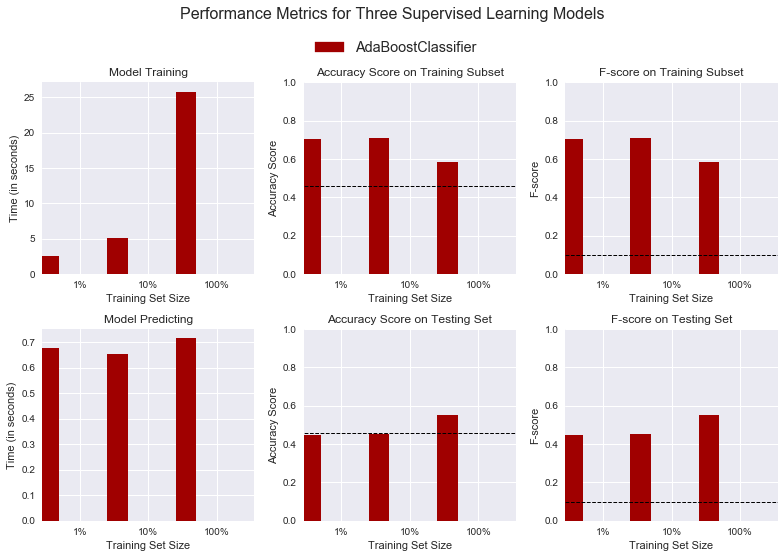

In [200]:
samples_100 = len(y_train_draw)
samples_10 = int(.10 * len(y_train_draw))
samples_1 = int(.01 * len(y_train_draw))

clf_C = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME.R",
                         n_estimators=1000, random_state = 1)
# Collect results on the learners
results = {}
for clf in [clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train_draw, y_train_draw, X_test_draw, y_test_draw)
# Run metrics visualization for the three supervised learning models chosen
DUMMY_BASE_ACCURACY = 0.46
DUMMY_BASE_F_SCORE = 0.1
vs.evaluate(results, DUMMY_BASE_ACCURACY, DUMMY_BASE_F_SCORE)

In [201]:
print results['AdaBoostClassifier']

{0: {'pred_time': 0.6771180629730225, 'f_test': 0.44662921348314594, 'train_time': 2.551640033721924, 'acc_train': 0.70666666666666667, 'acc_test': 0.44662921348314605, 'f_train': 0.70666666666666655}, 1: {'pred_time': 0.6548779010772705, 'f_test': 0.45388576779026207, 'train_time': 5.082812070846558, 'acc_train': 0.70999999999999996, 'acc_test': 0.45388576779026218, 'f_train': 0.70999999999999985}, 2: {'pred_time': 0.7166829109191895, 'f_test': 0.55032771535580516, 'train_time': 25.805109977722168, 'acc_train': 0.58666666666666667, 'acc_test': 0.55032771535580527, 'f_train': 0.58666666666666656}}


Normalized confusion matrix
[[ 0.51  0.08  0.41]
 [ 0.23  0.13  0.65]
 [ 0.13  0.07  0.8 ]]
Normalized confusion matrix
[[ 0.51  0.08  0.42]
 [ 0.23  0.12  0.66]
 [ 0.14  0.06  0.8 ]]


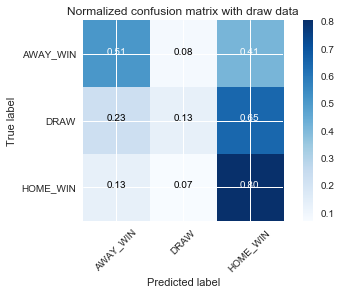

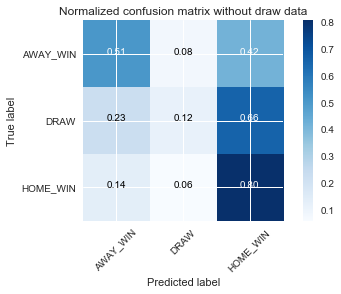

In [202]:
'''
CONFUSIOM MATRIX FOR ADABOOST
'''
y_pred_draw = clf_C.predict(X_test_draw)
cnf_matrix_adaboost_with_draw_data = confusion_matrix(y_test_draw, y_pred_draw)
np.set_printoptions(precision=2)


CLASSES_NAME = le.inverse_transform([0,1,2])


plt.figure()
plot_confusion_matrix(cnf_matrix_adaboost_with_draw_data, classes=CLASSES_NAME, normalize=True,
                      title='Normalized confusion matrix with draw data')

plt.figure()
plot_confusion_matrix(cnf_matrix_adaboost, classes=CLASSES_NAME, normalize=True,
                      title='Normalized confusion matrix without draw data')

In [203]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
# TODO: Initialize the classifier
clf = AdaBoostClassifier()

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
# I choose to perform a grid search on two params: the algorithm used for boosting and the number of estimators (early termination to avoid overfitting)
'''
MY BASE CLASSIFIER
clf_C = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME.R",
                         n_estimators=1000, random_state = 1)
                         
'''
parameters = {'base_estimator': [tree.DecisionTreeClassifier(max_depth=1),
                                tree.DecisionTreeClassifier(max_depth=2)], 
              'n_estimators': [1000], 
              'algorithm' : ['SAMME', 'SAMME.R'],
              'random_state' : [1]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5, average='weighted')

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()

grid_obj = GridSearchCV(clf, parameters, scoring = scorer, verbose = 5) #Turned the verbose option when I was running it

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_draw, y_train_draw)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 
[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.477469, total=  17.1s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, ma

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.5s remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.467988, total=  16.3s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.3s remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.467158, total=  17.3s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   52.1s remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.497252, total=  29.5s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s


[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME, score=0.492137, total=  29.7s
[CV] n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'), random_state=1, algorithm=SAMME 
[CV]  n_estimators=1000, base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, mi

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  5.0min finished


In [204]:
# Get the estimator
best_clf = grid_fit.best_estimator_
print best_clf

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train_draw, y_train_draw)).predict(X_test_draw)
best_predictions = best_clf.predict(X_test_draw)

# Report the before-and-afterscores
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test_draw, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test_draw, best_predictions, beta = 0.5, average='weighted'))

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=1000, random_state=1)

Optimized Model
------
Final accuracy score on the testing data: 0.5510
Final F-score on the testing data: 0.4872


# Running without draws

Considering data without any draws..
Training set has 12771 samples.
Testing set has 3193 samples.
QuadraticDiscriminantAnalysis trained on 127 samples.
QuadraticDiscriminantAnalysis trained on 1277 samples.
QuadraticDiscriminantAnalysis trained on 12771 samples.
MLPClassifier trained on 127 samples.
MLPClassifier trained on 1277 samples.
MLPClassifier trained on 12771 samples.
AdaBoostClassifier trained on 127 samples.
AdaBoostClassifier trained on 1277 samples.
AdaBoostClassifier trained on 12771 samples.


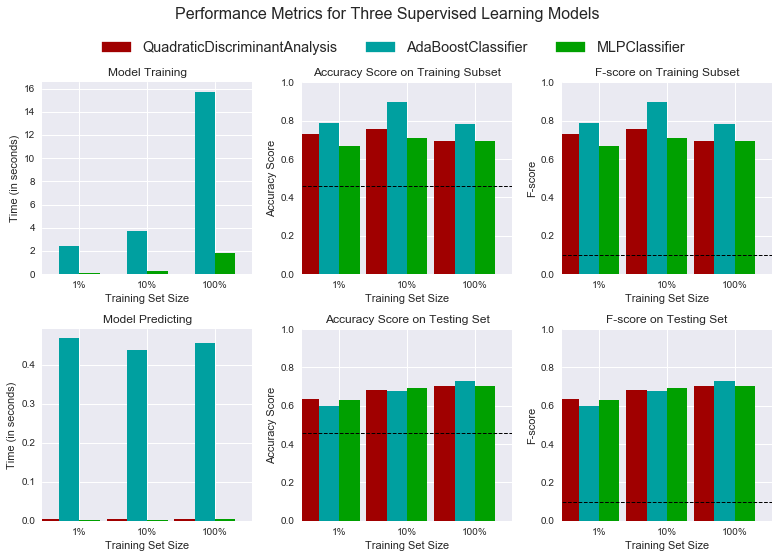

In [196]:
# Import train_test_split
print "Considering data without any draws.."
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train_only_draw, X_test_only_draw, y_train_only_draw, y_test_only_draw = train_test_split(final_all_features_no_draws, 
                                                    transformed_labels_no_draws, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train_draw.shape[0])
print "Testing set has {} samples.".format(X_test_draw.shape[0])

samples_100 = len(y_train_only_draw)
samples_10 = int(.10 * len(y_train_only_draw))
samples_1 = int(.01 * len(y_train_only_draw))
# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train_only_draw, y_train_only_draw, 
                                             X_test_only_draw, y_test_only_draw)
# Run metrics visualization for the three supervised learning models chosen
DUMMY_BASE_ACCURACY = 0.46
DUMMY_BASE_F_SCORE = 0.1
vs.evaluate(results, DUMMY_BASE_ACCURACY, DUMMY_BASE_F_SCORE)

### Confusion Matrix for no draws

{0: {'pred_time': 0.4684290885925293, 'f_test': 0.5981835264641403, 'train_time': 2.385586977005005, 'acc_train': 0.79000000000000004, 'acc_test': 0.5981835264641403, 'f_train': 0.79000000000000004}, 1: {'pred_time': 0.43698906898498535, 'f_test': 0.67804572502348881, 'train_time': 3.7110750675201416, 'acc_train': 0.90000000000000002, 'acc_test': 0.67804572502348892, 'f_train': 0.89999999999999991}, 2: {'pred_time': 0.4568369388580322, 'f_test': 0.73003445036016279, 'train_time': 15.737712144851685, 'acc_train': 0.78333333333333333, 'acc_test': 0.7300344503601629, 'f_train': 0.78333333333333333}}
******************************************************************
Confusion matrix for base case
Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]
******************************************************************
Confusion matrix for AdaBoost classifier
Normalized confusion matrix
[[ 0.53  0.47]
 [ 0.15  0.85]]


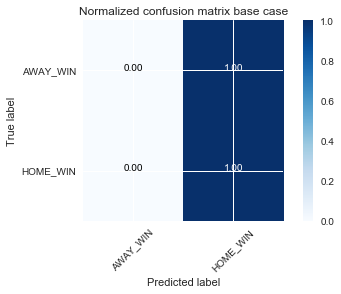

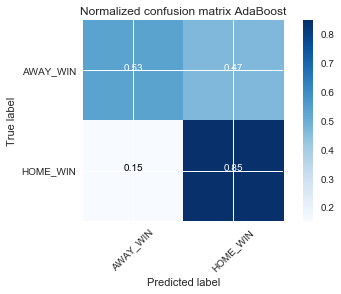

In [197]:
print results['AdaBoostClassifier']

'''
CONFUSIOM MATRIX FOR ADABOOST
'''
y_pred = clf_C.predict(X_test_only_draw)
cnf_matrix_adaboost_no_draws = confusion_matrix(y_test_only_draw, y_pred)
np.set_printoptions(precision=2)


CLASSES_NAME = le_draw.inverse_transform([0,1])

print "******************************************************************"
print "Confusion matrix for base case"
plt.figure()
plot_confusion_matrix(cnf_base_case_matrix_no_draws, classes=CLASSES_NAME, normalize=True,
                      title='Normalized confusion matrix base case')

print "******************************************************************"
print "Confusion matrix for AdaBoost classifier"
plt.figure()
plot_confusion_matrix(cnf_matrix_adaboost_no_draws, classes=CLASSES_NAME, normalize=True,
                      title='Normalized confusion matrix AdaBoost')


### Notes for report
The Holy Grail... ... is obviously to predict the outcome of the game. The bookies use 3 classes (Home Win, Draw, Away Win). They get it right about 53% of the time. This is also what I've achieved so far using my own SVM. Though it may sound high for such a random sport game, you've got to know that the home team wins about 46% of the time. So the base case (constantly predicting Home Win) has indeed 46% precision.

## Prediction Results and Optimizations

### Bookkeeper Odds, Compare vs them

### Accuracy across different countries, different seasona

## Conclusion